# 21M.387 Fundamentals of Music Processing
## Chord Recognition 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact

import sys
sys.path.append("../common")
from util import *
import fmp

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 3)

## Reading

Chapter 5.0 (pp 237-239), 5.2 (pp 253 - 272)

<img src="images/book_cover.png" width=200>

## Introduction

Goal - given a musical audio file with typical Western harmonies, identify the chords in the music.

### About Chords (Briefly)
- more than one note
- can be diads, triads, tetrad, or more.
- chords define the harmonic progression of a song.
- inversions
- actual chords, or implied chords via arpeggiation.

<img src="images/c_major_variants.png" width=600>

### Four types of common triads
- Major: (4, 3)
- Minor: (3, 4)
- Augmented: (4, 4)
- Diminished:  (3, 3)

### Various Representations

- Sheet Music
- Recorded Performance
- Chromagram Features
- Recognized Chords (ideal)

<img src="images/chords_representations.png" width=600>

### Overall Process

- Audio
- Chroma
- Pattern Matching
- Enhancements with Pre-filtering and Post-filtering

<img src="images/chord_recog_process.png" width=600>

## Template-Based Pattern Matching

Steps:

1. Convert audio into a feature space: we use chromagrams.
The sequence is $X = (x_1, x_2, \dots, x_n)$ where each $x_n$ is a $\mathbb{R}^{12}$ chroma vector.

2. To each $x_n$, apply a label $\lambda_n$ from the set of labels $\Lambda$.  
$\Lambda$ is the set of chords we wish to recognize.


We only consider the _major triads_ and _minor triads_, so:
$$\Lambda = \lbrace \mathbf{C, C \sharp, D, \dots Cm, C \sharp m, Dm, \dots } \rbrace$$

Example:

In [2]:
snd = load_wav("audio/beatles_let_it_be.wav", 0, 12.75)
fs = 22050.
ipd.Audio(snd, rate = fs)

### Chromagram
Make chromagram with:  
$N=4096$  
$H=2048$

Normalize chromagram with $l^2$ norm.

feature rate = 10.77 Hz


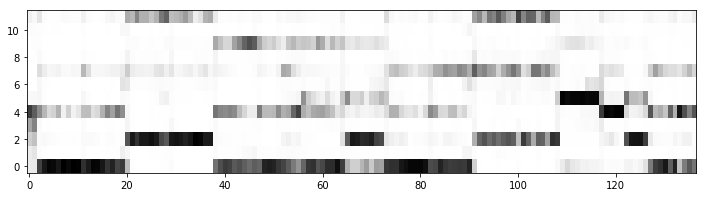

In [5]:
fft_len = 4096
hop_size = fft_len / 2
chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, 0)
plt.imshow(chroma, origin='lower', aspect='auto', cmap='Greys');

ff = fs / hop_size
print "feature rate = %.2f Hz" % ff

### Create $\lambda \in \Lambda$ and $t \in \mathcal{T}$

Now create $\Lambda$, a set of chord labels and $\mathcal{T}$, a set of templates.

Each template is simply a _binary vector_ that describes the notes in a chord

Example: __C major__

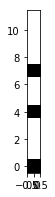

In [6]:
t = fmp.make_chord_template([0,4,7])
plt.imshow(np.atleast_2d(t).T, origin='lower', cmap='Greys');

Example: __D minor__ (the saddest of all keys)

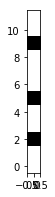

In [9]:
t = fmp.make_chord_template([2,5,9])
plt.imshow(np.atleast_2d(t).T, origin='lower', cmap='Greys');

Example: What chord is this?

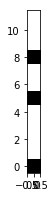

In [10]:
t = fmp.make_chord_template([0,5,8])
plt.imshow(np.atleast_2d(t).T, origin='lower', cmap='Greys');

### Compare 

Now, we compare a bunch of chord template $t_{\lambda}$ to every feature vector in the time series $X = (x_1, x_2, \dots, x_n)$

Each comparison yields a score. The comparison method will be our good friend the normalized dot product:
$$ s(t, x) = { \langle t, x \rangle \over \Vert t \Vert \cdot \Vert x \Vert } $$


For example, this is a single chroma vector $x_5$:

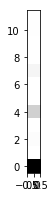

In [11]:
plt.imshow(chroma[:,5:6], origin='lower', cmap='Greys');

Here is the dot product of $x_5$ and various $t$'s

In [12]:
@interact(c=(0, 11))
def test_chord_dp(c):
    chords = [(np.array([0,4,7]) + k) % 12 for k in range(12) ]
    t = fmp.make_chord_template(chords[c])
    x = chroma[:,5:6]
    s = np.dot(t, x)
    plt.subplot(1,3,1)
    plt.imshow(np.atleast_2d(t).T, origin='lower', cmap='Greys');
    plt.subplot(1,3,2)
    plt.imshow(x, origin='lower', cmap='Greys')
    plt.text(-10, 4, '*', fontsize=50)
    plt.text(7, 5, '= %.3f' % s, fontsize=50)
    plt.show()

interactive(children=(IntSlider(value=5, description=u'c', max=11), Output()), _dom_classes=('widget-interact',))

If both $x$ and $t$ are normalized, the score calculation is just the dot product.

To find the label of $x_n$, use the _highest scoring_ template of all $t \in \mathcal{T}$.

### Template dictionary

We can express all the $t$s as a single matrix:

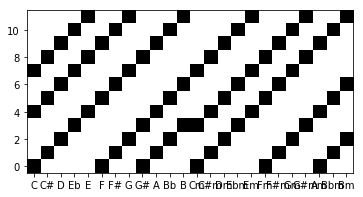

In [13]:
traids = fmp.make_triads_fb()
plt.imshow(traids.T, origin='lower', cmap='Greys');
fmp.chord_template_labels(1)

### Score Calculation 
The entire score calculation can then happen as a single Matrix Multiplication:

$$\mathbf{S} = \mathcal{T} \cdot \mathcal{C}$$

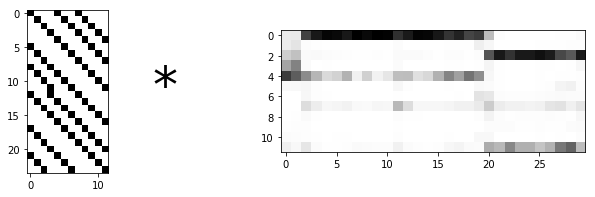

In [14]:
plt.subplot(1,2,1)
plt.imshow(traids, cmap='Greys');
plt.text(18, 13, '*', fontsize=50)
plt.subplot(1,2,2)
plt.imshow(chroma[:,:30], cmap='Greys');

This is the resulting score matrix. This looks a bit like a chromagram, but it is not. Each row is the score received for that particular chord template.

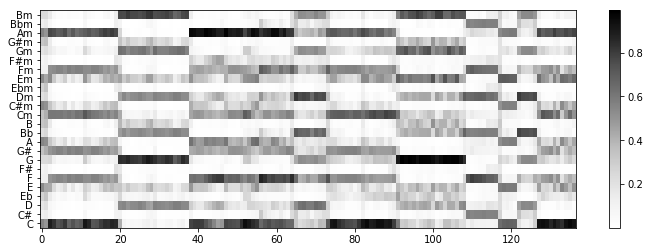

In [15]:
scores = np.dot(traids, chroma)

plt.rcParams['figure.figsize'] = (12, 4)
plt.imshow(scores, origin='lower', aspect='auto', cmap='Greys')
fmp.chord_template_labels()
plt.colorbar();

Now, for each column (ie, each time step), find the highest score of all 24 chords templates.

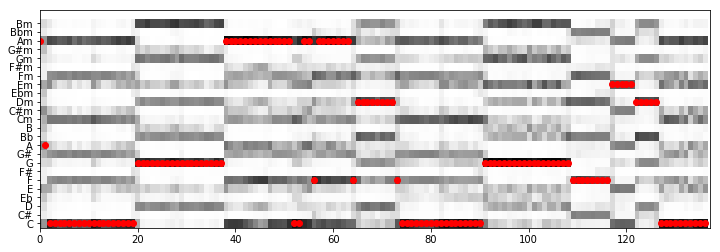

In [16]:
est_chords = np.argmax(scores, axis=0)

fmp.plot_matrix_and_points(scores, est_chords)
fmp.chord_template_labels()

And, to see them listed as a vector:

In [17]:
print est_chords

[21  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7 21 21 21 21 21 21 21 21 21 21 21 21
 21 21  0  0 21 21  5 21 21 21 21 21 21 21  5 14 14 14 14 14 14 14 14  5  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  5  5  5  5  5  5  5  5 16 16 16 16 16 14 14 14
 14 14  0  0  0  0  0  0  0  0  0  0]


## Evaluation

- Evaluation of MIR algorithms is a general issue, not just specific to chord recognition. For example:
  - Beat detection
  - Event classification
  - Segmentation (to be covered later)
  
- Most evaluations compare the computer-generated results with a "reference annotation", also known as _ground truth_.
- Questions:
  - how good / reliable is the ref annotation?
  - how should agreement / disagreement be quantified?
  - what about situations where the "truth" is ambiguous?
  
Most annotations come from expert humans, who generate annotations manually.

Example:

<img src="images/annotation_example.png" width=800>

Annotations in Sheet Music must be transferred to the actual audio recording, with each chord having a precise start and end time (in seconds).

One program that is sometimes used for this task is _Sonic Visualiser_:

In [18]:
import os
os.system('open audio/beatles_let_it_be.wav -a "Sonic Visualiser"')

256

The annotation itself is usually a text file. Here it is for "Let It Be":

In [19]:
for l in open('audio/beatles_let_it_be.lab').readlines():
    print l.strip()

0.000000 0.175157 N
0.175157 1.852358 C
1.852358 3.454535 G
3.454535 4.720022 A:min
4.720022 5.126371 A:min/b7
5.126371 5.950680 F:maj7
5.950680 6.774988 F:maj6
6.774988 8.423605 C
8.423605 10.014172 G
10.014172 11.651179 F
11.651179 13.392675 C
13.392675 15.018072 C
15.018072 16.527369 G
16.527369 17.734807 A:min
17.734807 18.129546 A:min/b7
18.129546 18.919024 F:maj7
18.919024 19.662063 F:maj6
19.662063 21.264240 C
21.264240 22.796757 G
22.796757 24.398934 F
24.398934 26.035941 C
26.035941 27.591678 C
27.591678 29.217074 G
29.217074 30.424167 A:min
30.424167 30.812726 A:min/b7
30.812726 31.562290 F:maj7
31.562290 32.293718 F:maj6
32.293718 33.930725 C
33.930725 35.590952 G
35.590952 37.169909 F
37.169909 37.982607 C
37.982607 38.783696 C/7
38.783696 40.490362 A:min
40.490362 42.115759 E:min/b3
42.115759 43.752766 F
43.752766 45.424603 C
45.424603 47.084829 C
47.084829 48.721836 G
48.721836 50.312403 F
50.312403 52.007460 C
52.007460 53.632857 C
53.632857 55.223424 G
55.223424 56.4446

The tasks now are:
- Read the annotation file
- Simplify any "out of scope" annotations
- Sample annotations to match $F_f$, the chroma feature rate.
- Compare each computer-generated result with this ground truth data.
- Report a summary score of "how will we did".

For complex chord annotations, we can just drop the "extra stuff". For example:
- `C` $\rightarrow$ C major
- `A:min/b7` $\rightarrow$ A minor
- `F:maj7` $\rightarrow$ F major

Sampling annotation data converts timestamps (in seconds) to samples. 

For example, here are the first 3 chord annotations:

In [20]:
for l in open('audio/beatles_let_it_be.lab').readlines()[:4]:
    print l.strip()

0.000000 0.175157 N
0.175157 1.852358 C
1.852358 3.454535 G
3.454535 4.720022 A:min


Here is the exact same data, but sampled at $F_f$:

In [21]:
gt = fmp.load_chord_annotation("audio/beatles_let_it_be.lab", ff)
for n, l in enumerate(gt[:40]):
    print "%d %.2f %d" % (n, n/ff, l)

0 0.00 -1
1 0.09 -1
2 0.19 0
3 0.28 0
4 0.37 0
5 0.46 0
6 0.56 0
7 0.65 0
8 0.74 0
9 0.84 0
10 0.93 0
11 1.02 0
12 1.11 0
13 1.21 0
14 1.30 0
15 1.39 0
16 1.49 0
17 1.58 0
18 1.67 0
19 1.76 0
20 1.86 7
21 1.95 7
22 2.04 7
23 2.14 7
24 2.23 7
25 2.32 7
26 2.41 7
27 2.51 7
28 2.60 7
29 2.69 7
30 2.79 7
31 2.88 7
32 2.97 7
33 3.07 7
34 3.16 7
35 3.25 7
36 3.34 7
37 3.44 21
38 3.53 21
39 3.62 21


The comparison is fairly straight forward. Compute the Score $S$ as:

$$S = { \text{# Correct} \over \text{ # Total} } $$

Note that there are more complex comparison situations, involving False Positives, False Negatives, True Positives, and True Negatives. We will get to that later this term.

In [22]:
gt = fmp.load_chord_annotation("audio/beatles_let_it_be.lab", ff)

correct, total, score = fmp.get_score_stats(est_chords, gt)
print 'Score = %d / %d = %.3f' % (correct, total, score)

Score = 104 / 137 = 0.759


### A word about datasets

Chris Harte's PhD thesis (2010) produced an amazingly accurate annotation set for most of the Beatles Catalog (178 songs in total).

See here http://isophonics.net/datasets

There are other datasets around, but researchers are always looking for more.

## Issues and Ambiguities

### Chord ambiguities due to simplified label set

<img src="images/chord_ambiguities.png" width=500>

### Acoustic ambiguities due to note harmonics
  - Example: C minor: C, Eb, G. Fifth harmonic of C is E. 

### Tuning
Example: "Let It Be" tuned up 40 cents

In [24]:
# original beatles
ipd.Audio(snd, rate=fs)

In [26]:
# detuned up by 40 cents
snd2 = load_wav("audio/detuned_let_it_be.wav")
ipd.Audio(snd2, rate=fs)

In [28]:
# calculate stuff for detuned version
chroma2 = fmp.make_chromagram(snd2, fs, fft_len, hop_size, 0)
scores2 = np.dot(traids, chroma2)
est_chords2 = np.argmax(scores2, axis=0)

Compare the chromagrams

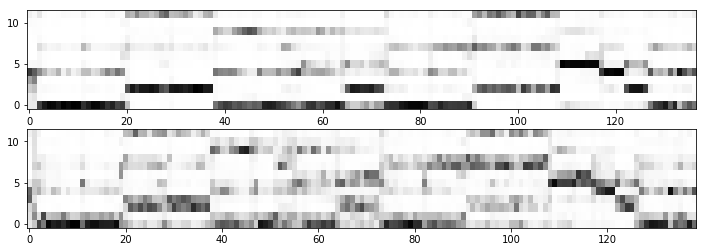

In [29]:
plt.subplot(2,1,1)
plt.imshow(chroma, origin='lower', aspect='auto', cmap='Greys');
plt.subplot(2,1,2)
plt.imshow(chroma2, origin='lower', aspect='auto', cmap='Greys');

Compare the Chord Template Probabilities

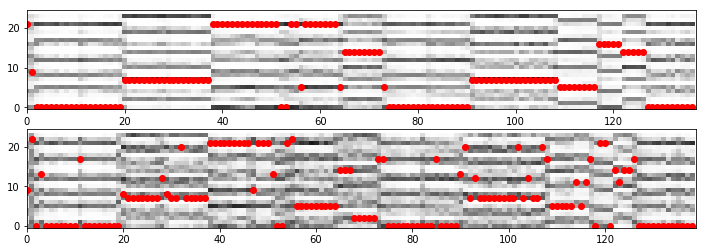

In [30]:
plt.figure()
plt.subplot(2,1,1)
fmp.plot_matrix_and_points(scores, est_chords)
plt.subplot(2,1,2)
fmp.plot_matrix_and_points(scores2, est_chords2)

### Segmentation (temporal) ambiguities
  - "Annotation speed"
  - Arpeggiation / Broken Chords

For example, Prelude 1, from Bach WTC:

In [32]:
snd = load_wav("audio/bach_prelude1_intro.wav")
ipd.Audio(snd, rate=fs)

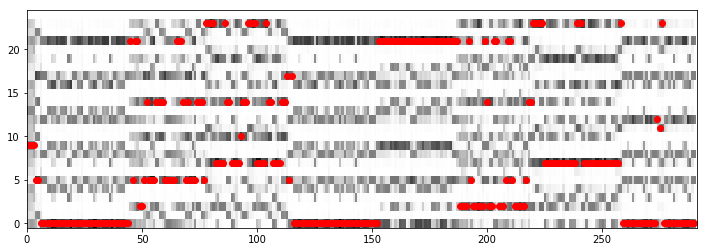

In [33]:
chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, 0)
scores = np.dot(traids, chroma)
est_chords = np.argmax(scores, axis=0)
fmp.plot_matrix_and_points(scores, est_chords)

In [34]:
gt = fmp.load_chord_annotation("audio/bach_prelude1_intro.lab", ff)

correct, total, score = fmp.get_score_stats(est_chords, gt)
print 'Score = %d / %d = %.3f' % (correct, total, score)

Score = 173 / 291 = 0.595


## Enhancement Strategies

### Spectral Enhancement

We generally see improvement with chromagram logarithmic compression. This helps bring up energies of softer notes.

$\Gamma_\gamma(v) = \log(1+ \gamma \cdot v)$

- $v$ is the value to compress
- $\gamma$ is the compression factor

$\mathcal{C}_\gamma =  \log(1+ \gamma \cdot \mathcal{C})$


Using a log-compressed chromagram in the first 30 seconds of _Let It Be_.

In [35]:
snd = load_wav("audio/beatles_let_it_be.wav", 0, 30)
gt = fmp.load_chord_annotation("audio/beatles_let_it_be.lab", ff)

@interact(g_idx = (0,4))
def show_score(g_idx=0):
    gamma = (0, .01, .1, 1, 10)[g_idx]    
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, gamma, True)
    traids = fmp.make_triads_fb()
    scores = np.dot(traids, chroma)
    est_chords = np.argmax(scores, axis=0)
    score = fmp.calc_chord_score(est_chords, gt)
    
    txt =  "Gamma = %.2f\nScore = %.3f" % (gamma, score) 
    plt.subplot(2,1,1)
    plt.imshow(chroma, origin='lower', aspect='auto', cmap='Greys');
    plt.text(0, 13, txt, fontsize=18)
    plt.subplot(2,1,2)
    fmp.plot_matrix_and_points(scores, est_chords)
    plt.show()

interactive(children=(IntSlider(value=0, description=u'g_idx', max=4), Output()), _dom_classes=('widget-interact',))

### Templates with Harmonics

We can add "artificial overtones" to the chord templates based on the overtone series

<img src="images/overtones.png" width=600>

Instead of a binary chord template, each note in a chord contributes energy for its harmonic overtones as well.

Example: $\mathbf{C2}$ has the energy corresponding to the following notes (for the first 8 harmonics):  
$$\mathbf{C2, C3, G3, C4, E4, G4, B\flat4, C5}$$

We can model a note of a "standard harmonic instrument" by assigning energy to each harmonic as an exponentially decaying series with decay factor $\alpha < 1.0$:

$
\begin{align}
\mathbf{C2} & \rightarrow 1.0 \\
\mathbf{C3} & \rightarrow \alpha \\
\mathbf{G3} & \rightarrow \alpha^2 \\
\mathbf{C4} & \rightarrow \alpha^3 \\
\mathbf{E4} & \rightarrow \alpha^4 \\
\mathbf{G4} & \rightarrow \alpha^5 \\
\mathbf{B\flat4} & \rightarrow \alpha^6 \\
\mathbf{C5} & \rightarrow \alpha^7 \\
\end{align}
$

In [36]:
@interact(alpha=(0.0,1.0))
def template_with_decay(alpha=0):
    t = fmp.make_chord_template([0,4,7], alpha)
    plt.imshow(np.atleast_2d(t).T, origin='lower', cmap='Greys');
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description=u'alpha', max=1.0), Output()), _dom_classes=('widget-interact',))

The full 24-chord template matrix with $\alpha = 0.7$

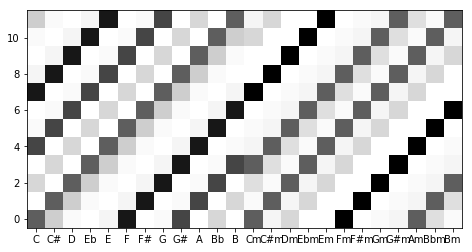

In [37]:
traids = fmp.make_triads_fb(0.7)
plt.imshow(traids.T, origin='lower', cmap='Greys');
fmp.chord_template_labels(1)

Applying enhanced templates and log compression

In [38]:
snd = load_wav("audio/beatles_let_it_be.wav", 0, 30)
gt = fmp.load_chord_annotation("audio/beatles_let_it_be.lab", ff)

@interact(g_idx = (0,4), alpha = (0., 1.))
def show_score(g_idx=0, alpha=0):
    gamma = (0, 0.01, .1, 1, 10)[g_idx]    
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, gamma, True)
    traids = fmp.make_triads_fb(alpha)
    scores = np.dot(traids, chroma)
    est_chords = np.argmax(scores, axis=0)
    score = fmp.calc_chord_score(est_chords, gt)
    
    txt =  "Gamma = %.2f\nAlpha = %.2f\nScore = %.3f" % (gamma, alpha, score) 
    plt.subplot(2,1,1)
    plt.imshow(chroma, origin='lower', aspect='auto', cmap='Greys');
    plt.text(0, 13, txt, fontsize=18)
    plt.subplot(2,1,2)
    fmp.plot_matrix_and_points(scores, est_chords)
    plt.show();

interactive(children=(IntSlider(value=0, description=u'g_idx', max=4), FloatSlider(value=0.0, description=u'alpha', max=1.0), Output()), _dom_classes=('widget-interact',))

### Learned Templates

- Create chord template dictionary by averaging annotated chormas
- In practice, this does not help much
- Could lead to over-fitting


### Temporal enhancement

Another enhancement (or _prefiltering_) that helps the performance of chord recognition is to smooth the time axis.

Chords typically change on a fairly long time frame. For example, in _Let It Be_:
- Song Length = $240$ seconds
- Number of Chord changes = $160$
- Average duration of a single chord, $T_c = {240 \over 160} = 1.5$ seconds

The feature rate for this Chromagram is: $F_f = 10.76$Hz

We have approximately $T_c \cdot F_f \simeq 16$ chroma vectors per chord.

This suggests that we can apply temporal smoothing to get rid of bumps in the chromagram.

For each row in the chromagram $x(n)$, we substitute the following smoothed row:

$$ x^L(n) = {1 \over L} \sum_{l=-(L-1)/2}^{(L-1)/2}x(n+l) $$


In [39]:
snd = load_wav("audio/beatles_let_it_be.wav", 0, 30)
gt = fmp.load_chord_annotation("audio/beatles_let_it_be.lab", ff)

@interact(win_len = (0, 20))
def show_score(win_len=0):
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, 1, True)
    if win_len != 0:
        chroma = fmp.temporal_smoothing(chroma, win_len)
    traids = fmp.make_triads_fb(0.7)
    scores = np.dot(traids, chroma)
    est_chords = np.argmax(scores, axis=0)
    score = fmp.calc_chord_score(est_chords, gt)
    
    txt =  "Win Len = %d\nScore = %.3f" % (win_len, score) 
    plt.subplot(2,1,1)
    plt.imshow(chroma, origin='lower', aspect='auto', cmap='Greys');
    plt.text(0, 13, txt, fontsize=18)
    plt.subplot(2,1,2)
    fmp.plot_matrix_and_points(scores, est_chords)
    plt.show()

interactive(children=(IntSlider(value=0, description=u'win_len', max=20), Output()), _dom_classes=('widget-interact',))

In [40]:
snd = load_wav("audio/bach_prelude1_intro.wav")
gt = fmp.load_chord_annotation("audio/bach_prelude1_intro.lab", ff)

@interact(win_len = (1, 30))
def show_score(win_len=1):
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, 1, True)
    chroma = fmp.temporal_smoothing(chroma, win_len)
    traids = fmp.make_triads_fb(0.6)
    scores = np.dot(traids, chroma)
    est_chords = np.argmax(scores, axis=0)
    score = fmp.calc_chord_score(est_chords, gt)
    
    txt =  "Win Len = %d\nScore = %.3f" % (win_len, score) 
    plt.subplot(2,1,1)
    plt.imshow(chroma, origin='lower', aspect='auto', cmap='Greys');
    plt.text(0, 13, txt, fontsize=18)
    plt.subplot(2,1,2)
    fmp.plot_matrix_and_points(scores, est_chords)
    plt.show()


interactive(children=(IntSlider(value=1, description=u'win_len', max=30, min=1), Output()), _dom_classes=('widget-interact',))

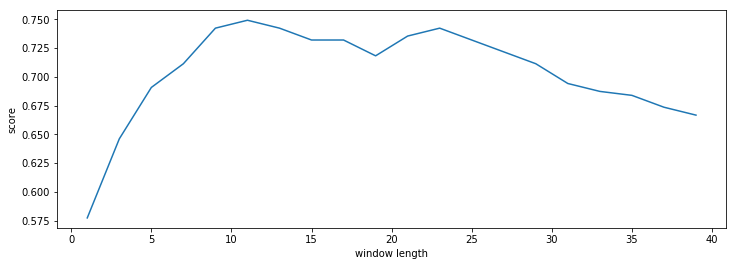

In [41]:
def score_per_win_len():
    win_len = np.arange(1, 40, 2)
    score = np.zeros(len(win_len))
    for i, w in enumerate(win_len):
        chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, 1, True)
        chroma = fmp.temporal_smoothing(chroma, w)
        traids = fmp.make_triads_fb(0.6)
        scores = np.dot(traids, chroma)
        est_chords = np.argmax(scores, axis=0)
        score[i] = fmp.calc_chord_score(est_chords, gt)
    return win_len, score

win_len, score = score_per_win_len()
plt.plot(win_len, score)
plt.xlabel("window length")
plt.ylabel("score");